## Reproductible fitting 

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy

from jmstate import MultiStateJointModel
from jmstate.utils import *

torch.manual_seed(42)

In [60]:
def log_weibull(t1, t0, lambda_, rho_):
    t = t1 - t0
    lambda_ = torch.as_tensor(lambda_, dtype=torch.float32)
    rho_ = torch.as_tensor(rho_, dtype=torch.float32)
    eps = 1e-8
    t = t + eps
    return torch.log(rho_ / lambda_) + (rho_ - 1) * torch.log(t / lambda_)


def double_slope(t, x, psi):
    x0 = psi[:, [0]]
    a = psi[:, [1]]
    b1 = psi[:, [2]]
    b2 = psi[:, [3]]
    corr = torch.where(t > x0, (b2 - b1) * (t - x0), torch.zeros_like(t))
    return (a + b1 * t + corr).unsqueeze(-1)


def double_slope_grad(t, x, psi):
    x0 = psi[:, [0]]
    b1 = psi[:, [2]]
    b2 = psi[:, [3]]
    return torch.where(t <= x0, b1, b2).unsqueeze(-1)


f = lambda gamma, b: gamma + b

In [61]:
##############################################

lambda_T01 = 6.3358
rho_T01 = 1.9093
lambda_T02 = 4.2441
rho_T02 = 3.1623
lambda_T12 = 5.701
rho_T12 = 1.4848

##############################################

gamma = torch.tensor([1.4566, 2.3329, -1.3877, 0.1774])
Q_inv = torch.tensor([2.2529, 1.3496, 0.5134, 0.7750])
R_inv = torch.tensor([1.1963])
Q_sqrt = torch.matrix_exp(-torch.diag(Q_inv))
R_sqrt = torch.exp(-R_inv)
alphas = {
    (0, 1): torch.tensor([5.1656]),
    (0, 2): torch.tensor([4.8410]),
    (1, 2): torch.tensor([0.8901]),
}
betas = {
    (0, 1): torch.tensor([-1.3434]),
    (0, 2): torch.tensor([-0.9148]),
    (1, 2): torch.tensor([-0.5497]),
}

##############################################

real_params = ModelParams(
    gamma,
    (Q_inv, "diag"),
    (R_inv, "ball"),
    alphas,
    betas
)

In [62]:
log_weibull_T01 = lambda t1, t0: log_weibull(t1, t0, lambda_T01, rho_T01)
log_weibull_T02 = lambda t1, t0: log_weibull(t1, t0, lambda_T02, rho_T02)
log_weibull_T12 = lambda t1, t0: log_weibull(t1, t0, lambda_T12, rho_T12)

surv = {
    (0, 1): (log_weibull_T01, double_slope_grad),
    (0, 2): (log_weibull_T02, double_slope_grad),
    (1, 2): (log_weibull_T12, double_slope_grad),
}

In [63]:
model_design = ModelDesign(
    f,
    double_slope,
    surv
)

In [64]:
real_model = MultiStateJointModel(model_design, real_params)

n, p = 500, 1
t = torch.linspace(0, 15, 16)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, 1) 
b = torch.randn(n, real_params.gamma.shape[0]) @ Q_sqrt
psi = f(real_params.gamma, b)

In [65]:
trajectories_init = [[(0.0, 0)] for _ in range(n)]

sample_data = SampleData(
    x,
    trajectories_init,
    psi
)

trajectories = real_model.sample_trajectories(sample_data, c)

In [66]:
c_min = torch.tensor(
    [
        (
            min(c[i].item(), trajectories[i][-1][0])
            if trajectories[i][-1][1] == 2
            else c[i].item()
        )
        for i in range(len(trajectories))
    ]
)

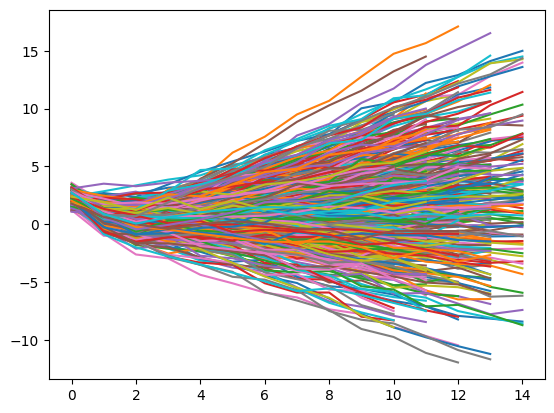

In [67]:
y = model_design.h(t, x, psi)
y += torch.randn_like(y) * R_sqrt
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan
plt.plot(t, y.squeeze(-1).T)
plt.show()

In [68]:
init_params = ModelParams(
    torch.tensor([2.0, 2.0, -1.0, 1.0]),
    (torch.zeros_like(Q_inv), "diag"),
    (torch.zeros_like(R_inv), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

model = MultiStateJointModel(model_design, init_params)

In [69]:
data = ModelData(
    x,
    t,
    y,
    trajectories,
    c
)

In [70]:
buckets = build_buckets(trajectories)
print([(key, buckets[key][0].numel()) for key in buckets.keys()])

[((0, 1), 190), ((1, 2), 175), ((0, 2), 292)]


In [71]:
history = []
acceptance = []
step_sizes = []

def callback():
    history.append([p.detach().clone() for p in model.params_.as_list])
    acceptance.append(model.sampler_.acceptance_rate)
    step_sizes.append(model.sampler_.step_size)

model.fit(data, callback=callback, n_iter=3000, batch_size=4)

Computing Fisher Information Matrix: 100%|██████████| 1000/1000 [00:24<00:00, 40.50it/s]


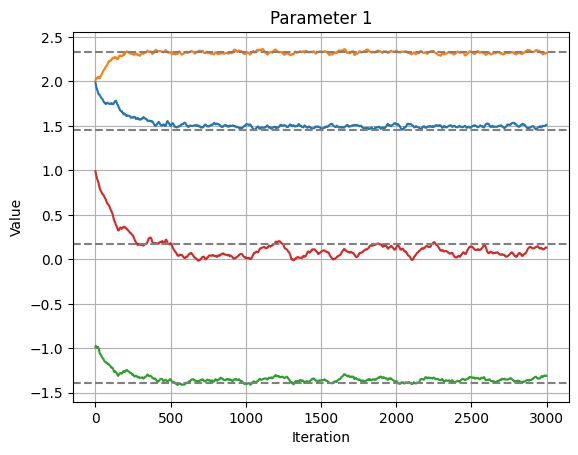

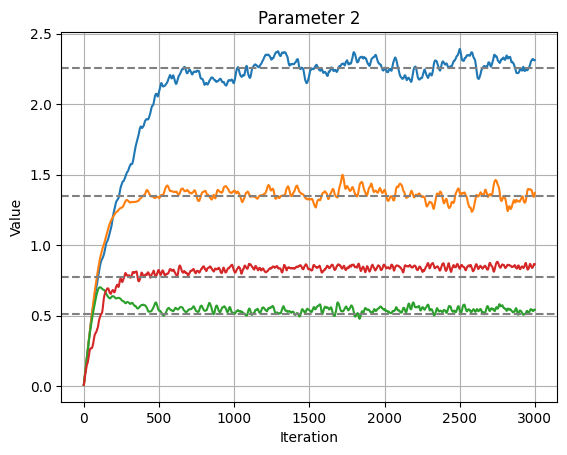

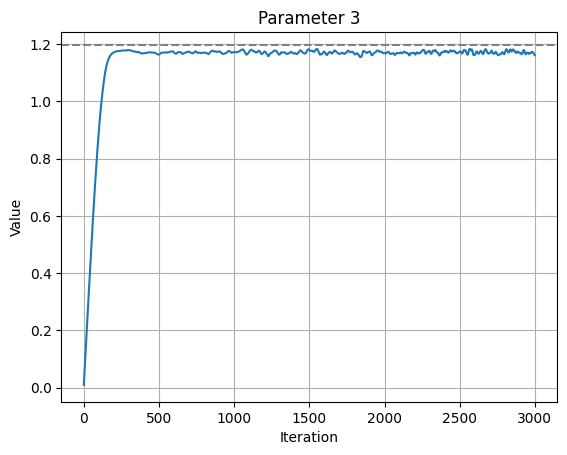

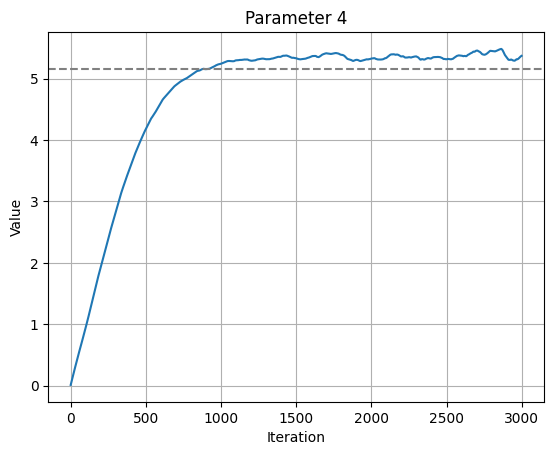

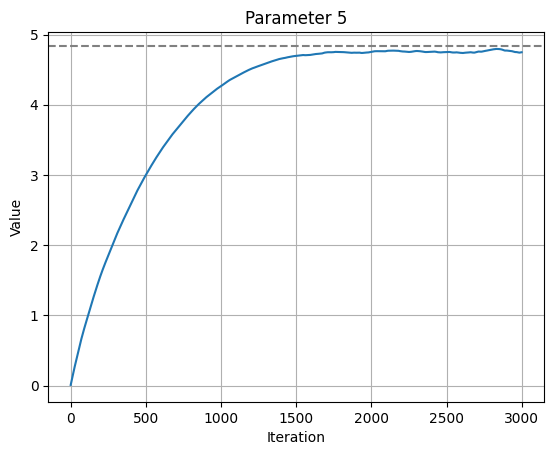

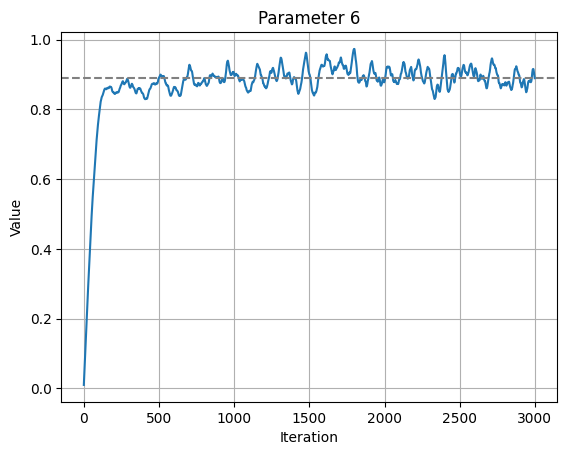

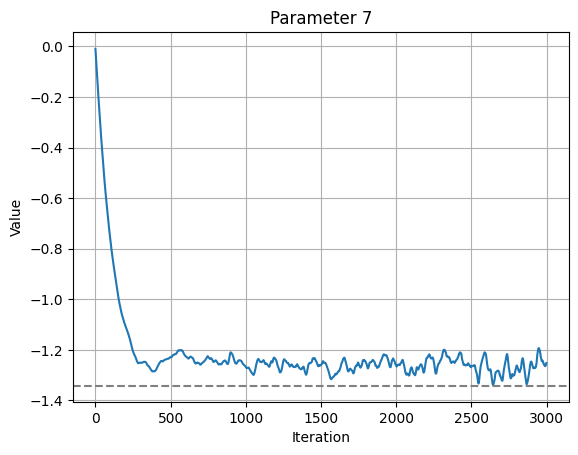

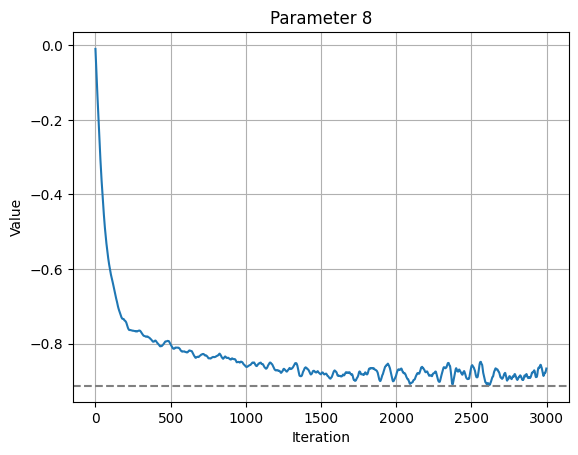

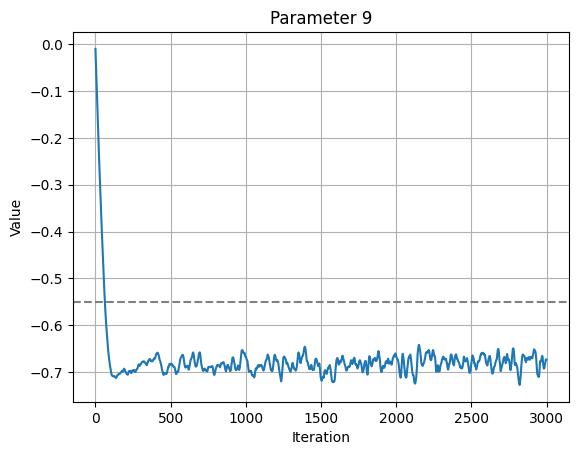

In [72]:
real_params_list = real_params.as_list

for i in range(len(history[0])):
    history_vstack = np.vstack([elt[i].numpy().reshape(1, -1) for elt in history])

    for j in range(history_vstack.shape[1]):
        plt.plot(np.arange(history_vstack.shape[0]), history_vstack[:, j])

        plt.axhline(y=float(real_params_list[i][j]), linestyle="--", color="gray")

    plt.title(f"Parameter {i + 1}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

In [73]:
print("Estimation")
print(model.params_)
print("Standard Error")
print(model.get_stderror())

Estimation
ModelParams(gamma=tensor([ 1.5112,  2.3179, -1.3106,  0.1329], requires_grad=True), Q_info=(tensor([2.3117, 1.3709, 0.5432, 0.8649], requires_grad=True), 'diag'), R_info=(tensor([2.3117, 1.3709, 0.5432, 0.8649], requires_grad=True), 'diag'), alphas={(0, 1): tensor([5.3740], requires_grad=True), (0, 2): tensor([4.7477], requires_grad=True), (1, 2): tensor([0.8895], requires_grad=True)}, betas={(0, 1): tensor([-1.2518], requires_grad=True), (0, 2): tensor([-0.8668], requires_grad=True), (1, 2): tensor([-0.6735], requires_grad=True)})
Standard Error
ModelParams(gamma=tensor([0.0105, 0.0275, 0.0234, 0.0024]), Q_info=(tensor([0.0666, 0.0660, 0.0795, 0.0689]), 'diag'), R_info=(tensor([0.0666, 0.0660, 0.0795, 0.0689]), 'diag'), alphas={(0, 1): tensor([0.4041]), (0, 2): tensor([0.3474]), (1, 2): tensor([0.4116])}, betas={(0, 1): tensor([0.2066]), (0, 2): tensor([0.1511]), (1, 2): tensor([0.2378])})


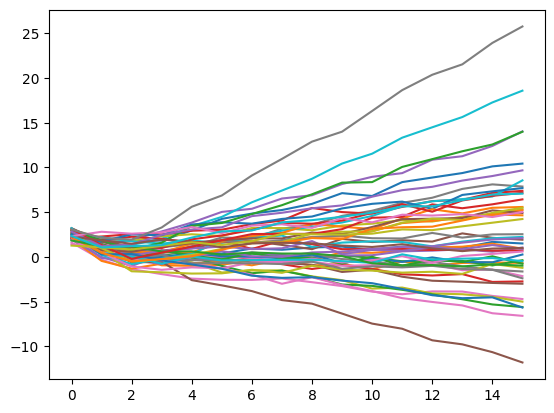

In [74]:
model = real_model

N = 50

Q = model.params_.get_precision("Q").detach()
Q = torch.linalg.inv(Q)

R = model.params_.get_precision("R").detach()
R = torch.linalg.inv(R)

b_sim = torch.randn(N, model.params_.gamma.detach().shape[0]) @ torch.tensor(scipy.linalg.sqrtm(Q.numpy()))
psi_sim = f(model.params_.gamma, b_sim)
x_sim = torch.randn(N, 1) 

y_sim = model.model_design.h(t, x_sim, psi_sim)
y_sim += torch.randn_like(y_sim) @ torch.tensor(scipy.linalg.sqrtm(R.numpy()))
plt.plot(t, y_sim.squeeze(-1).T.detach().numpy())
plt.show()

In [75]:
trajectories_init = [trajectory[:1] for trajectory in trajectories[:N]]

sample_data = SampleData(x_sim, trajectories_init, psi_sim)

trajectories_sim = model.sample_trajectories(sample_data, [2.0 for _ in range(N)])
print(trajectories_sim)

[[(0.0, 0), (1.240783929824829, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.437958002090454, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.485656976699829, 2)], [(0.0, 0)], [(0.0, 0), (1.403503656387329, 1)], [(0.0, 0)], [(0.0, 0), (1.972748041152954, 2)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.953338861465454, 2)], [(0.0, 0)], [(0.0, 0), (1.843719720840454, 1)], [(0.0, 0), (1.603241205215454, 1)], [(0.0, 0)], [(0.0, 0), (1.828674554824829, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.814941644668579, 2)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.874298334121704, 1)], [(0.0, 0)], [(0.0, 0), (1.499023675918579, 1)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0)], [(0.0, 0), (1.562317132949829, 1)], [(0.0, 0), (1.570282220840454, 1)], [(0.0, 0), (1.529968500137329, 2)], [(0.0, 0), (1.370544672012329, 1)]]


In [76]:
log_probs_list = model.compute_surv_log_probs(sample_data, torch.linspace(2.0, 20.0, 100).repeat(N, 1))

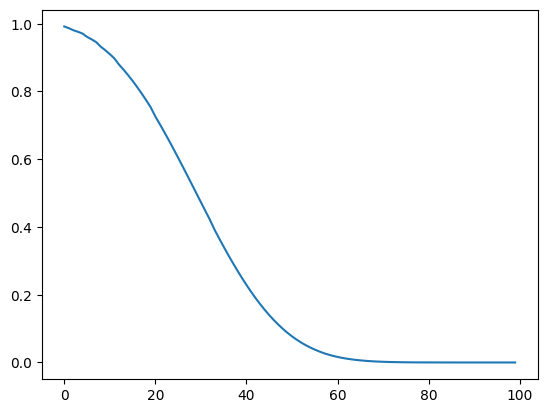

In [77]:
plt.plot(torch.exp(log_probs_list[2]))